# CNN Multi Output Asus4onE

* /dataset_Asus4onE/*.wav

In [1]:
import os
import time as ti
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import model_selection
from sklearn import preprocessing

import librosa
import librosa.display

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import IPython.display as ipd

In [2]:
base_dir = "C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/datasets/"
dataset_dir = os.path.join(base_dir, "dataset_Asus4onE_color/")
paths = glob.glob(dataset_dir+"*.wav")
npz_dir = os.path.join("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/npzs/", "dataset_Asus4onE_color_1000_np/")
model_dir = "C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_color_1000/"

In [3]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    # サンプリングレートはデフォルトで22050
    x, fs = librosa.load(file_path)
    return x, fs

def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(y=x, rate=rate)
    if len(x) > input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

def change_volume(x, rate=1.0):
    return x * rate

def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(dataset_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

def pathname2onehot(name):
    dst = []
    if len(name) == 6:
        for i in range(6):
            dst.append(int(name[i:i+1]))
        return dst
    else:
        print("Name size isnot 6")

def decimal2bin(decimal_num):
    return bin(int(decimal_num))[2:].zfill(6)
    
def convert_one_hot(src_y, string_num, dst_y):
    if src_y[string_num] == 1:
        dst_y[1] = 1
    else:
        dst_y[0] = 1

In [4]:
freq = 128
time = 517

In [5]:
x = []
y = []

for path in paths:
    file_name = os.path.split(path)[1]
    x.append(file_name)
    y.append(int(file_name[:6], 2))

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

#x_val, x_test, y_val, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)
#print("x train:{0}\ny train:{1}\nx val:{2}\ny val:{3}\nx test:{4}\ny test:{5}".format(len(x_train),len(y_train),len(x_val),len(y_val), len(x_test), len(y_test)))

x train:800
y train:800
x test:200
y test:200


In [6]:
# test data
path = os.path.join(npz_dir, "gar_melsp_test.npz")
if not os.path.exists(path):
    save_np_data(path, x_test, y_test)

# train data
path = os.path.join(npz_dir, "gar_melsp_train_raw.npz")
if not os.path.exists(path):
    save_np_data(path, x_train,  y_train)

path = os.path.join(npz_dir, "gar_melsp_train_wn.npz")
if not os.path.exists(path):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data(path, x_train,  y_train, aug=add_white_noise, rates=rates)

path = os.path.join(npz_dir, "gar_melsp_train_ss.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data(path, x_train,  y_train, aug=shift_sound, rates=rates)

# path = os.path.join(npz_dir, "gar_melsp_train_st.npz")
# if not os.path.exists(path):
#     rates = np.random.choice(np.arange(80,120),len(y_train))/100
#     save_np_data(path, x_train,  y_train, aug=stretch_sound, rates=rates)

path = os.path.join(npz_dir, "gar_melsp_train_cv.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(30,200),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=change_volume, rates=rates)

path = os.path.join(npz_dir, "gar_melsp_train_co.npz")
if not os.path.exists(path):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(dataset_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        x = change_volume(x=x, rate=np.random.randint(30,200)/100)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            # x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
            x = x
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez(path, x=np_data, y=np_targets)

In [7]:
_train_files = ["gar_melsp_train_raw.npz", 
               "gar_melsp_train_ss.npz",
               "gar_melsp_train_wn.npz",
               "gar_melsp_train_cv.npz",
               "gar_melsp_train_co.npz"]
_test_file = "gar_melsp_test.npz"

train_files = [os.path.join(npz_dir, path) for path in _train_files]
test_file = os.path.join(npz_dir, _test_file)

In [8]:
train_num = len(x_train)
test_num = len(x_test)

In [9]:
train_num

800

In [10]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

# 訓練データのロード
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]


# テストデータのロード
test_data = np.load(test_file)
_x_test = test_data["x"]
y_test = test_data["y"]

x_train = x_train.reshape(train_num*5, freq, time, 1)
_x_test = _x_test.reshape(test_num, freq, time, 1)

In [11]:
y_train_1 = np.zeros(train_num*5*2).reshape(train_num*5, 2)
y_train_2 = np.zeros(train_num*5*2).reshape(train_num*5, 2)
y_train_3 = np.zeros(train_num*5*2).reshape(train_num*5, 2)
y_train_4 = np.zeros(train_num*5*2).reshape(train_num*5, 2)
y_train_5 = np.zeros(train_num*5*2).reshape(train_num*5, 2)
y_train_6 = np.zeros(train_num*5*2).reshape(train_num*5, 2)

_y_test_1 = np.zeros(test_num*2).reshape(test_num, 2)
_y_test_2 = np.zeros(test_num*2).reshape(test_num, 2)
_y_test_3 = np.zeros(test_num*2).reshape(test_num, 2)
_y_test_4 = np.zeros(test_num*2).reshape(test_num, 2)
_y_test_5 = np.zeros(test_num*2).reshape(test_num, 2)
_y_test_6 = np.zeros(test_num*2).reshape(test_num, 2)

In [12]:
for i in range(len(y_train)):
    binaly_name = decimal2bin(y_train[i])
    one_hot_list = pathname2onehot(binaly_name)
    convert_one_hot(one_hot_list, 0, y_train_1[i])
    convert_one_hot(one_hot_list, 1, y_train_2[i])
    convert_one_hot(one_hot_list, 2, y_train_3[i])
    convert_one_hot(one_hot_list, 3, y_train_4[i])
    convert_one_hot(one_hot_list, 4, y_train_5[i])
    convert_one_hot(one_hot_list, 5, y_train_6[i])

for i in range(len(y_test)):
    binaly_name = decimal2bin(y_test[i])
    one_hot_list = pathname2onehot(binaly_name)
    convert_one_hot(one_hot_list, 0, _y_test_1[i])
    convert_one_hot(one_hot_list, 1, _y_test_2[i])
    convert_one_hot(one_hot_list, 2, _y_test_3[i])
    convert_one_hot(one_hot_list, 3, _y_test_4[i])
    convert_one_hot(one_hot_list, 4, _y_test_5[i])
    convert_one_hot(one_hot_list, 5, _y_test_6[i])

In [13]:
half_size = len(_x_test) // 2

x_val = _x_test[:half_size]
x_test = _x_test[half_size:]

y_val_1 = _y_test_1[:half_size]
y_test_1 = _y_test_1[half_size:]
y_val_2 = _y_test_2[:half_size]
y_test_2 = _y_test_2[half_size:]
y_val_3 = _y_test_3[:half_size]
y_test_3 = _y_test_3[half_size:]
y_val_4 = _y_test_4[:half_size]
y_test_4 = _y_test_4[half_size:]
y_val_5 = _y_test_5[:half_size]
y_test_5 = _y_test_5[half_size:]
y_val_6 = _y_test_6[:half_size]
y_test_6 = _y_test_6[half_size:]

In [14]:
print("x train:{0}\ny train:{1}\nx val:{2}\ny val:{3}\nx test:{4}\ny test:{5}".format(len(x_train),len(y_train_1),len(x_val),len(y_val_1), len(x_test), len(y_test_1)))

x train:4000
y train:4000
x val:100
y val:100
x test:100
y test:100


In [15]:
def cba(inputs, filters, kernel_size, strides, dropout=False):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout:
        x = Dropout(0.2)(x)
    return x

inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x_5 = cba(inputs, filters=32, kernel_size=(1,128), strides=(1,2))
x_5 = cba(x_5, filters=32, kernel_size=(128,1), strides=(2,1))
x_5 = cba(x_5, filters=64, kernel_size=(1,128), strides=(1,2))
x_5 = cba(x_5, filters=64, kernel_size=(128,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4, x_5])
# x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,32), strides=(1,2))
x = cba(x, filters=128, kernel_size=(32,1), strides=(2,1))

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_1 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_1 = GlobalAveragePooling2D()(output_1)
output_1 = Dense(units=2, activation='softmax', name='output_1')(output_1)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_2 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_2 = GlobalAveragePooling2D()(output_2)
output_2 = Dense(units=2, activation='softmax', name='output_2')(output_2)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_3 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_3 = GlobalAveragePooling2D()(output_3)
output_3 = Dense(units=2, activation='softmax', name='output_3')(output_3)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_4 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_4 = GlobalAveragePooling2D()(output_4)
output_4 = Dense(units=2, activation='softmax', name='output_4')(output_4)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_5 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_5 = GlobalAveragePooling2D()(output_5)
output_5 = Dense(units=2, activation='softmax', name='output_5')(output_5)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_6 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_6 = GlobalAveragePooling2D()(output_6)
output_6 = Dense(units=2, activation='softmax', name='output_6')(output_6)


model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4, output_5, output_6])

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, amsgrad=True)

model.compile(optimizer=opt, 
              loss={'output_1': 'categorical_crossentropy', 
                    'output_2': 'categorical_crossentropy',
                    'output_3': 'categorical_crossentropy',
                    'output_4': 'categorical_crossentropy',
                    'output_5': 'categorical_crossentropy',
                    'output_6': 'categorical_crossentropy'},
              metrics={'output_1': 'accuracy', 
                       'output_2': 'accuracy',
                       'output_3': 'accuracy',
                       'output_4': 'accuracy',
                       'output_5': 'accuracy',
                       'output_6': 'accuracy'})

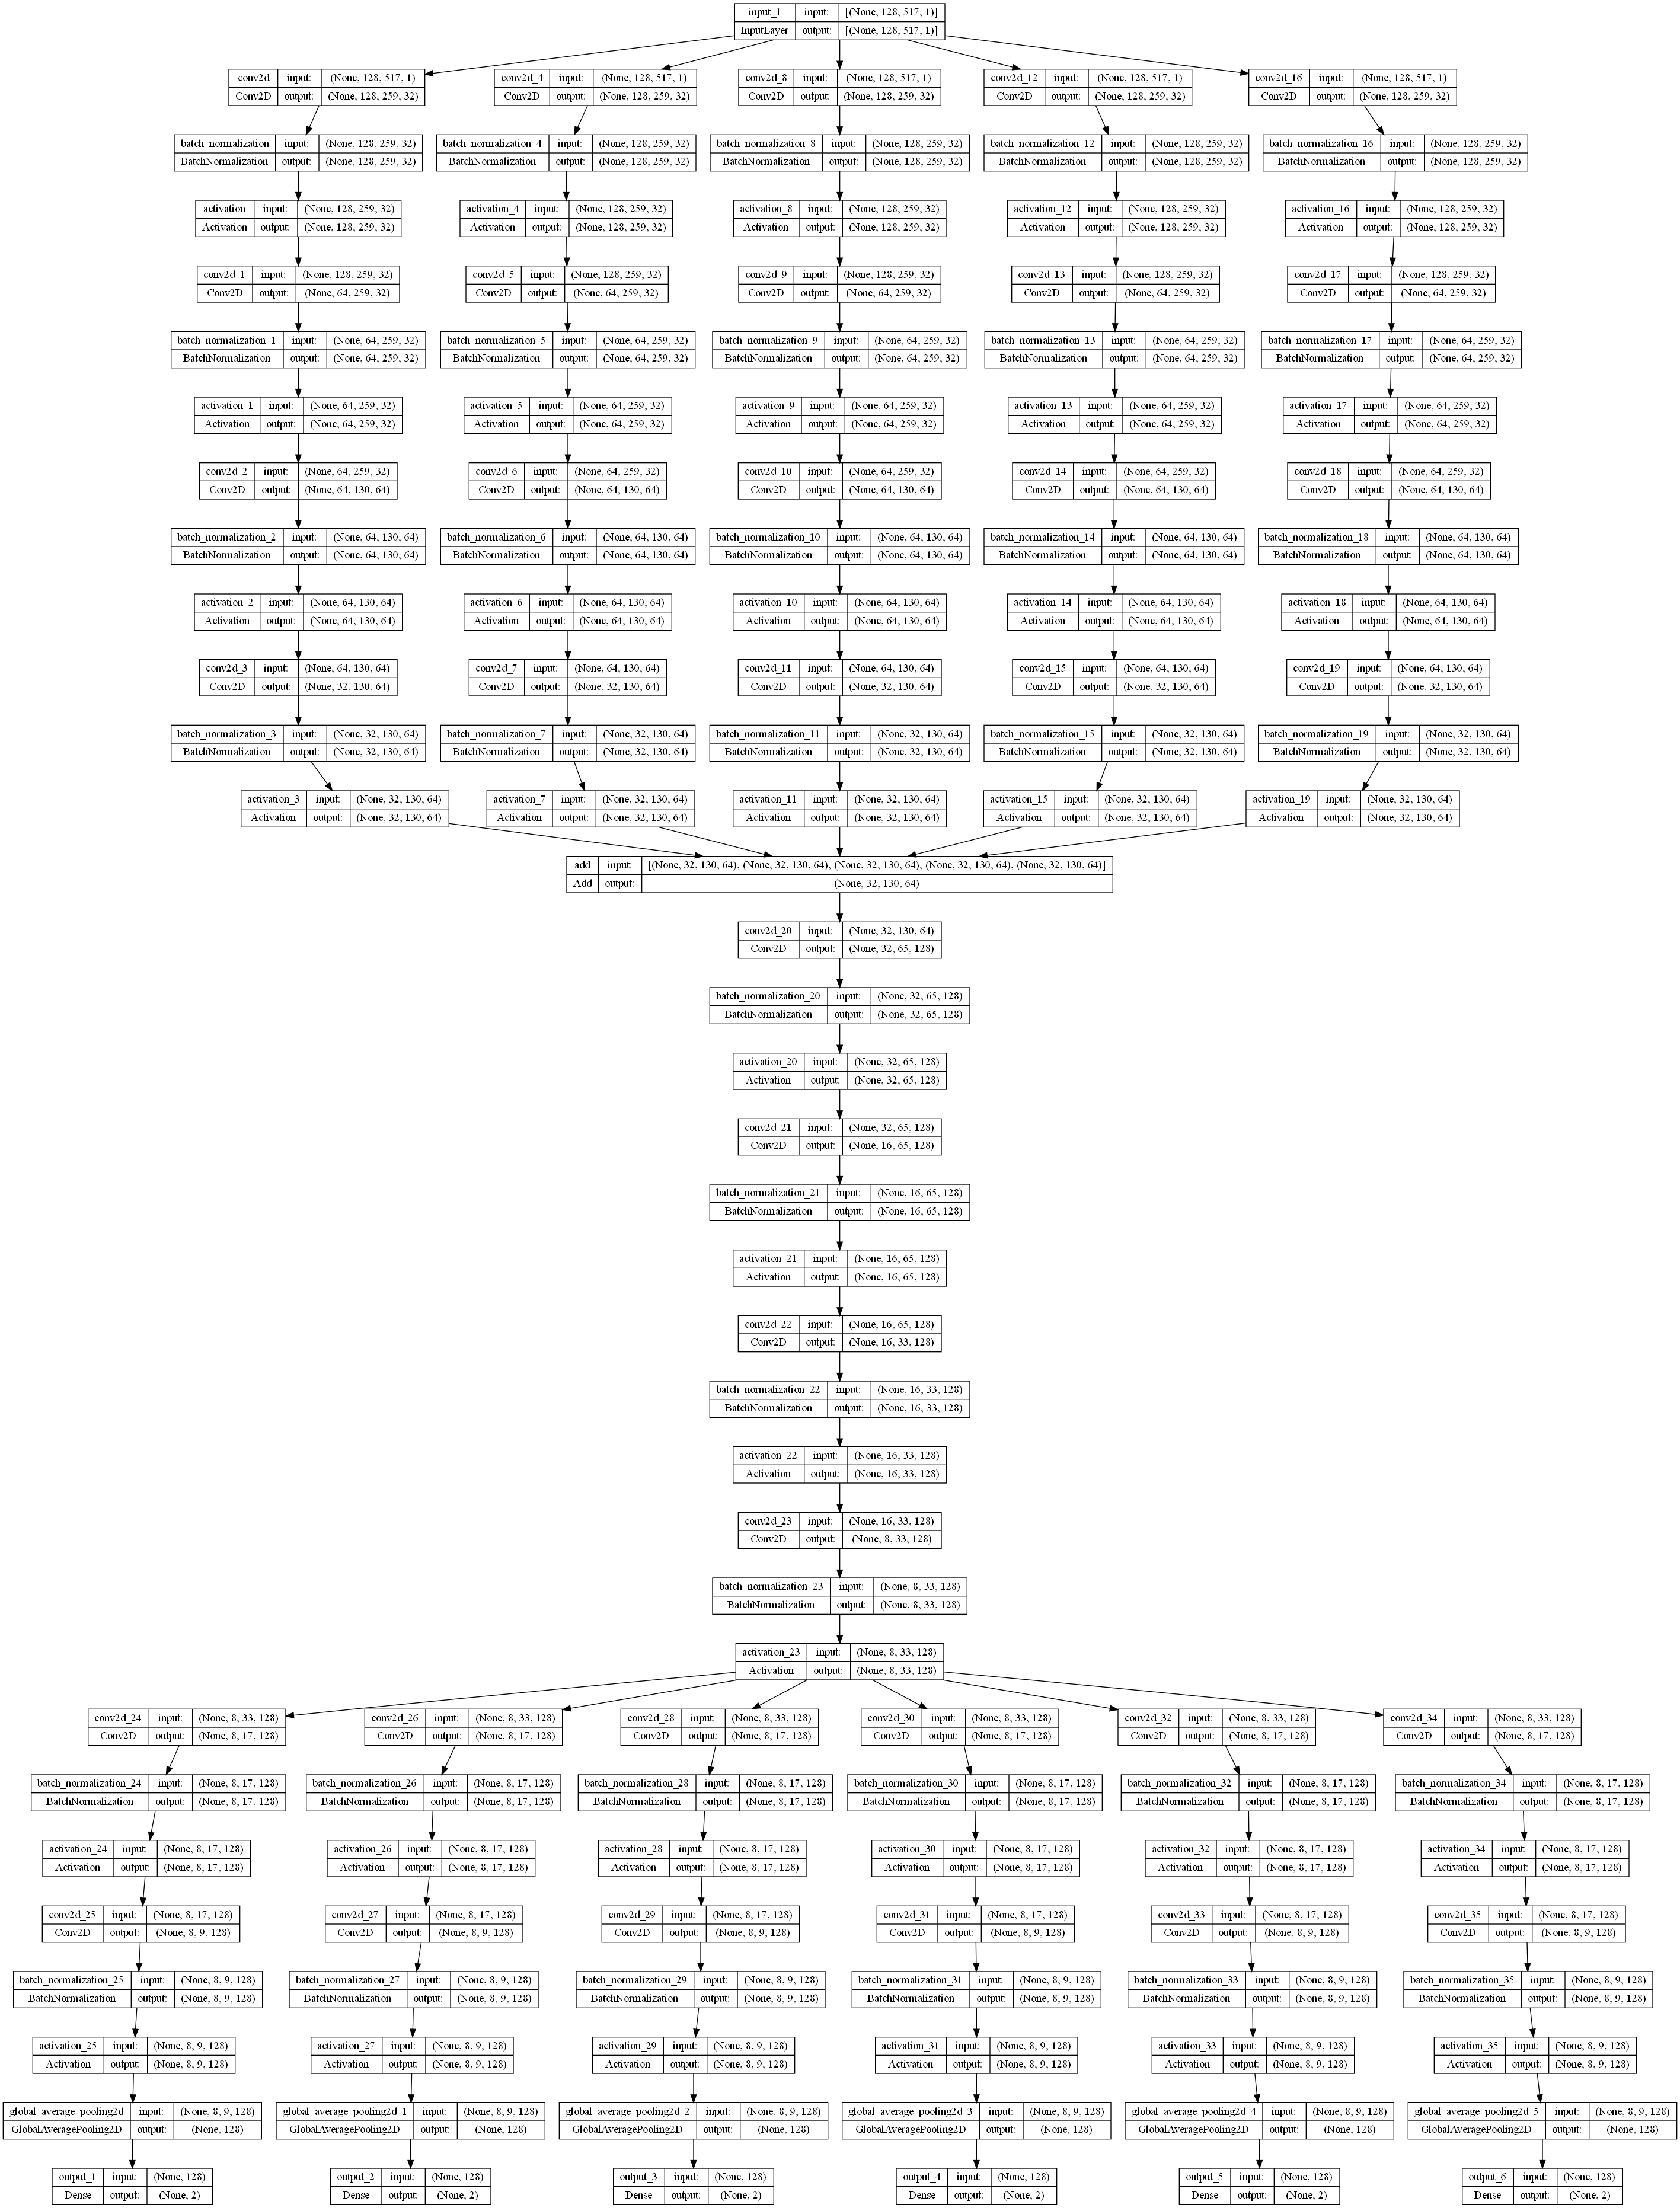

In [16]:
plot_model(
    model,
    show_shapes=True,
)

In [17]:
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [18]:
es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'As4_color_.{epoch:02d}_{val_loss:.4f}_{output_1_accuracy:.4f}_{output_2_accuracy:.4f}_{output_3_accuracy:.4f}_{output_4_accuracy:.4f}_{output_5_accuracy:.4f}_{output_6_accuracy:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [19]:
batch_size = 12
epochs = 20

start_time = ti.time()
with tensorflow.device('/GPU:0'):
    
    history = model.fit(x_train, 
                      {'output_1': y_train_1, 
                       'output_2': y_train_2,
                       'output_3': y_train_3,
                       'output_4': y_train_4,
                       'output_5': y_train_5,
                       'output_6': y_train_6},
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val,
                                       {'output_1': y_val_1,
                                        'output_2': y_val_2,
                                        'output_3': y_val_3,
                                        'output_4': y_val_4,
                                        'output_5': y_val_5,
                                        'output_6': y_val_6}),
                      verbose=1,
                      callbacks=[es_cb, cp_cb])

    
end_time = ti.time()
print("time:", end_time - start_time)

Epoch 1/20
334/334 [==============================] - ETA: 0s - loss: 1.5262 - output_1_loss: 0.1712 - output_2_loss: 0.2353 - output_3_loss: 0.2181 - output_4_loss: 0.2442 - output_5_loss: 0.1724 - output_6_loss: 0.4849 - output_1_accuracy: 0.9280 - output_2_accuracy: 0.8997 - output_3_accuracy: 0.8980 - output_4_accuracy: 0.8953 - output_5_accuracy: 0.9225 - output_6_accuracy: 0.7135
Epoch 1: val_loss improved from inf to 1.13951, saving model to C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_color_1000\As4_color_.01_1.1395_0.9280_0.8997_0.8980_0.8953_0.9225_0.7135.hdf5
334/334 [==============================] - 197s 522ms/step - loss: 1.5262 - output_1_loss: 0.1712 - output_2_loss: 0.2353 - output_3_loss: 0.2181 - output_4_loss: 0.2442 - output_5_loss: 0.1724 - output_6_loss: 0.4849 - output_1_accuracy: 0.9280 - output_2_accuracy: 0.8997 - output_3_accuracy: 0.8980 - output_4_accuracy: 0.8953 - output_5_accuracy: 0.9225 - output_6_accuracy: 0.7135 - val_l

In [23]:
del(model)

In [4]:
# model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_1500/As4Drop_.12_0.0407_0.9990_0.9993_0.9973_0.9988_0.9985_0.9958.hdf5")
# model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_1000/As4_.10_0.0074_0.9994_1.0000_0.9946_0.9946_0.9973_0.9946.hdf5")
model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_color_1000/As4_color_.08_0.0161_0.9973_0.9965_0.9985_0.9960_0.9958_0.9942.hdf5")

In [21]:
evaluation = model.evaluate(x_test, {'output_1': y_test_1,
                                     'output_2': y_test_2,
                                     'output_3': y_test_3,
                                     'output_4': y_test_4,
                                     'output_5': y_test_5,
                                     'output_6': y_test_6})
print(evaluation)

4/4 [==============================] - 4s 265ms/step - loss: 0.0161 - output_1_loss: 4.0866e-04 - output_2_loss: 0.0120 - output_3_loss: 5.9408e-04 - output_4_loss: 4.8039e-04 - output_5_loss: 6.9711e-04 - output_6_loss: 0.0020 - output_1_accuracy: 1.0000 - output_2_accuracy: 0.9900 - output_3_accuracy: 1.0000 - output_4_accuracy: 1.0000 - output_5_accuracy: 1.0000 - output_6_accuracy: 1.0000
[0.01614299975335598, 0.00040866475319489837, 0.012009786441922188, 0.0005940772243775427, 0.00048039338435046375, 0.0006971137481741607, 0.001952964230440557, 1.0, 0.9900000095367432, 1.0, 1.0, 1.0, 1.0]


000000_020.wav
wave size:(66150,)
melsp size:(128, 517)
sampling rate:22050


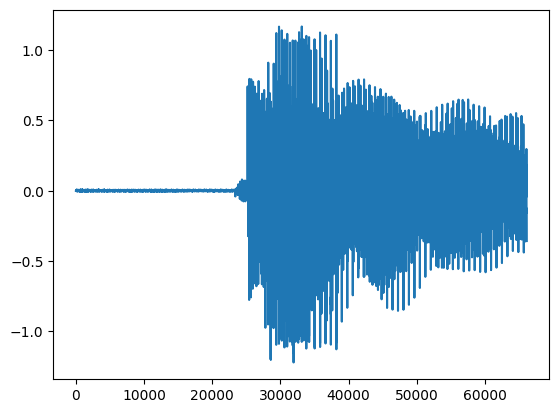

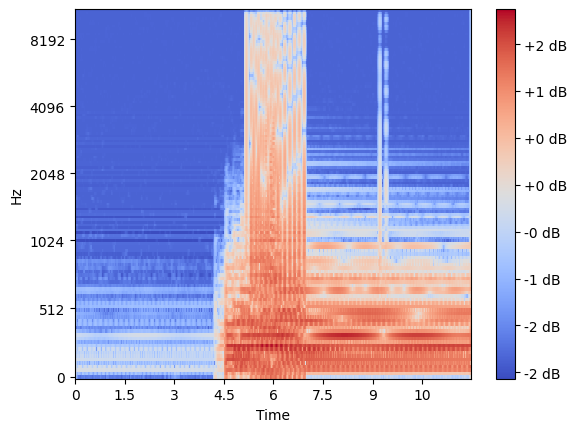

In [27]:
file_name = "000000" + "_" + str(20).zfill(3) + ".wav"
print(file_name)
x, fs = load_wave_data(dataset_dir, file_name)
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [28]:
ipd.Audio(x, rate=fs)

In [29]:
pred = model.predict(melsp.reshape(1, 128, 517, 1))

1/1 [==============================] - 1s 890ms/step


In [76]:
pred_label_1 = np.argmax(pred[0])
pred_label_2 = np.argmax(pred[1])
pred_label_3 = np.argmax(pred[2])
pred_label_4 = np.argmax(pred[3])
pred_label_5 = np.argmax(pred[4])
pred_label_6 = np.argmax(pred[5])

In [31]:
print(f"predicted output 1: {pred_label_1}\npredicted output 2: {pred_label_2}\npredicted output 3: {pred_label_3}\npredicted output 4: {pred_label_4}\npredicted output 5: {pred_label_5}\npredicted output 6: {pred_label_6}")

predicted output 1: 0
predicted output 2: 0
predicted output 3: 0
predicted output 4: 0
predicted output 5: 0
predicted output 6: 0


In [5]:
import sounddevice as sd

In [9]:
fs = 22050
sd.default.device = [1, 10]
duration = 3

data = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

x = data.reshape(len(data))
melsp = calculate_melsp(x)
# show_wave(x)
# show_melsp(melsp, fs)

pred = model.predict(melsp.reshape(1, 128, 517, 1))
pred_label_1 = np.argmax(pred[0])
pred_label_2 = np.argmax(pred[1])
pred_label_3 = np.argmax(pred[2])
pred_label_4 = np.argmax(pred[3])
pred_label_5 = np.argmax(pred[4])
pred_label_6 = np.argmax(pred[5])
print(f"predicted output 1: {pred_label_1}\npredicted output 2: {pred_label_2}\npredicted output 3: {pred_label_3}\npredicted output 4: {pred_label_4}\npredicted output 5: {pred_label_5}\npredicted output 6: {pred_label_6}")

1/1 [==============================] - 0s 20ms/step
predicted output 1: 0
predicted output 2: 0
predicted output 3: 0
predicted output 4: 0
predicted output 5: 0
predicted output 6: 0


In [40]:
pred

[array([[1.0000000e+00, 4.4981306e-08]], dtype=float32),
 array([[9.9999928e-01, 6.8790047e-07]], dtype=float32),
 array([[1.6442547e-04, 9.9983549e-01]], dtype=float32),
 array([[0.9683239 , 0.03167616]], dtype=float32),
 array([[9.99892354e-01, 1.07642314e-04]], dtype=float32),
 array([[9.9955529e-01, 4.4466727e-04]], dtype=float32)]

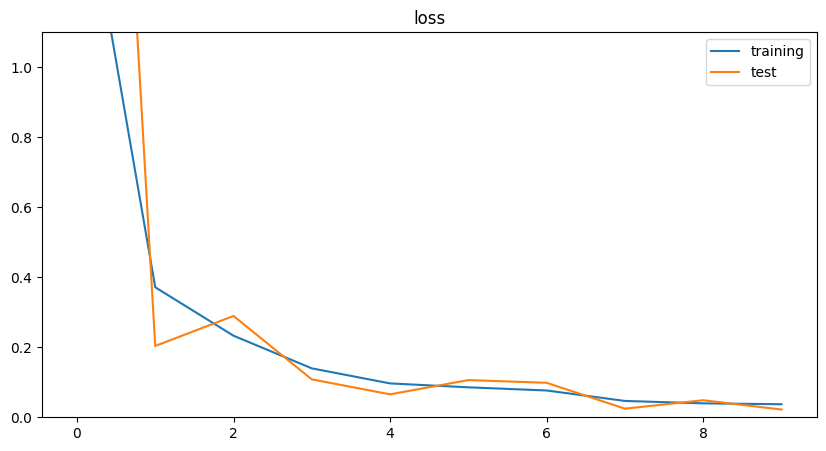

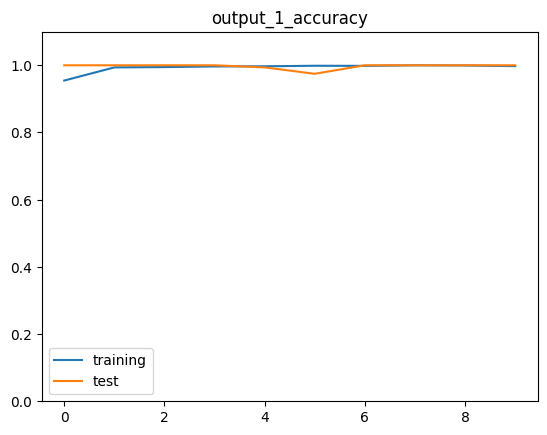

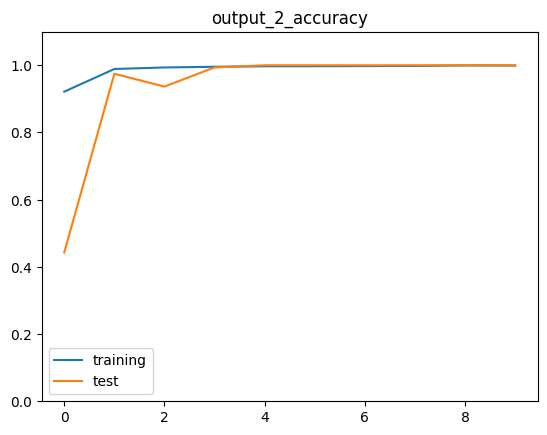

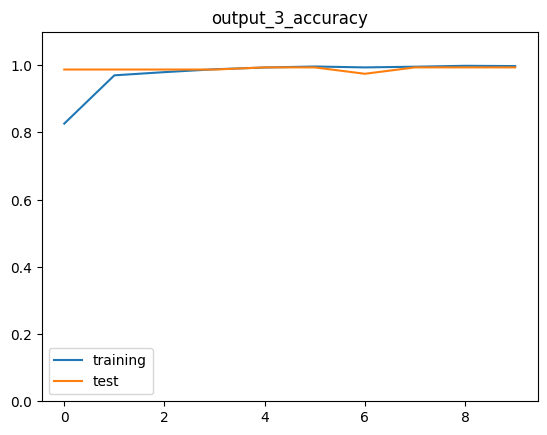

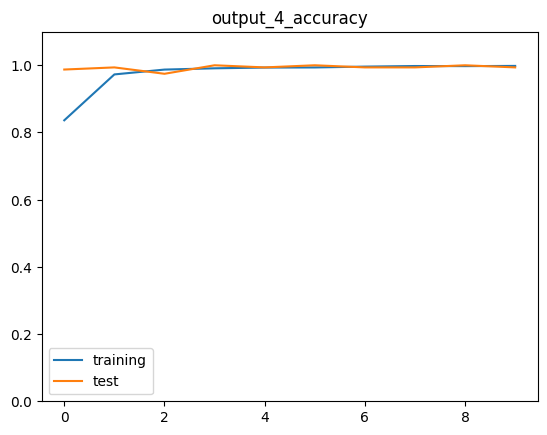

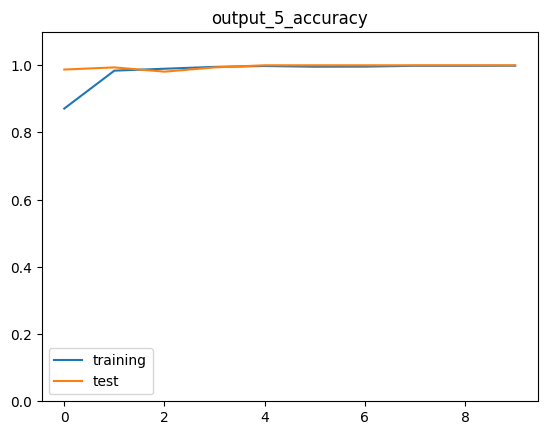

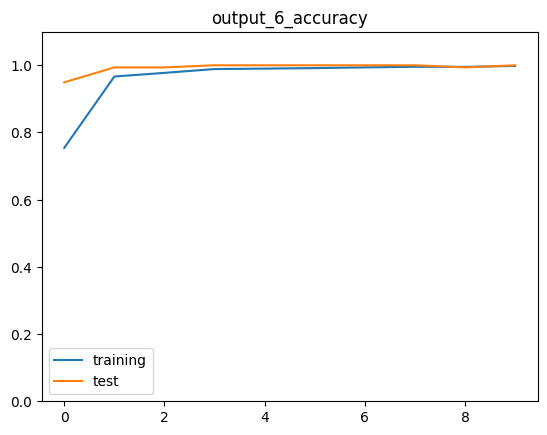

<Figure size 640x480 with 0 Axes>

In [107]:
metrics = ['loss', 
           'output_1_accuracy', 
           'output_2_accuracy',
           'output_3_accuracy',
           'output_4_accuracy',
           'output_5_accuracy',
           'output_6_accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
 
for i in range(0, 7):
 
    metric = metrics[i]
 
    plt.subplot(1, 1, 1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
    plt.title(metric)  # グラフのタイトルを表示
    
    plt_train = history.history[metric]  # historyから訓練データの評価を取り出す
    plt_test = history.history['val_' + metric]  # historyからテストデータの評価を取り出す
    
    plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
    plt.plot(plt_test, label='test')  # テストデータの評価をグラフにプロット
    plt.legend()  # ラベルの表示
    plt.ylim(0, 1.1)
    
    plt.show()  # グラフの表示
    plt.savefig(model_dir + metric + ".png")